In [1]:
import pandas as pd
import numpy as np
import ast

import os
import matplotlib.pyplot as plt
import seaborn as sns
from plinder_analysis_utils import DockingAnalysisBase, PoseBustersAnalysis, PropertyAnalysis

import statsmodels.formula.api as smf


In [2]:
PLINDER_TEST_COLUMNS = [
    "system_id", "ligand_smiles",
    # binary 
    # "ligand_is_covalent", "ligand_is_ion", "ligand_is_cofactor", "ligand_is_artifact",
    # discrete
    "system_num_protein_chains",
    "ligand_num_rot_bonds", "ligand_num_hbd", "ligand_num_hba", "ligand_num_rings",
    # continuous
    "entry_resolution", "entry_validation_molprobity", 
    "system_num_pocket_residues", "system_num_interactions",
    "ligand_molecular_weight", "ligand_crippen_clogp", 
    "ligand_num_interacting_residues", "ligand_num_neighboring_residues", "ligand_num_interactions",
]
# Create category mapping for visualization
CATEGORY_MAPPING = {
    "ligand_is_covalent": "binary",
    "ligand_is_ion": "binary",
    "ligand_is_cofactor": "binary",
    "ligand_is_artifact": "binary",
    "system_num_protein_chains": "discrete",
    "ligand_num_rot_bonds": "continuous",    
    "ligand_num_hbd": "continuous",
    "ligand_num_hba": "continuous",
    "ligand_num_rings": "continuous",
    "entry_resolution": "continuous",
    "entry_validation_molprobity": "continuous",
    "system_num_pocket_residues": "continuous",
    "system_num_interactions": "continuous",
    "ligand_molecular_weight": "continuous",
    "ligand_crippen_clogp": "continuous",
    "ligand_num_interacting_residues": "continuous",
    "ligand_num_neighboring_residues": "continuous",
    "ligand_num_interactions": "continuous",
    "ligand_is_artifact": "binary"     
}

In [3]:
df_combined = pd.read_csv("plinder_set_0_annotated.csv")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_7147/2737273468.py:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv("plinder_set_0_annotated.csv")


In [4]:
# build a boolean mask: drop any row where covalent, ionic or has_ion is True
# mask = ~(
#     df_combined['ligand_is_covalent'] |
#     df_combined['ligand_is_ion'] |
#     df_combined['has_ion'] |
#     df_combined['ligand_is_cofactor']
# )

# # filter and reset index
# df_combined = df_combined.loc[mask].reset_index(drop=True)
print("Filtered shape:", df_combined.shape)

Filtered shape: (26726, 154)


In [5]:
# First analyze multiple properties
property_analysis = PropertyAnalysis(df_combined)
methods = ["surfdock", "gnina", "chai-1", "diffdock_pocket_only", "icm", "vina"]

## Complementarity Between Physics-based and ML-based: Mixed Effect Analysis

### Prepare the df

In [6]:
MIXED_EFFECT_VARS = [
    "protein", "rmsd","method",
    # "system_id", "ligand_smiles",
    # binary 
    # "ligand_is_covalent", "ligand_is_ion", "ligand_is_cofactor", "ligand_is_artifact",
    # discrete
    # "system_num_protein_chains",
    "ligand_num_rot_bonds", "ligand_num_hbd", "ligand_num_hba", "ligand_num_rings",
    # continuous
    "entry_resolution", "entry_validation_molprobity", 
    # "system_num_pocket_residues", 
    "system_num_interactions",
    "ligand_molecular_weight", "ligand_crippen_clogp", 
    "ligand_num_interacting_residues", 
    "ligand_num_neighboring_residues", 
    # "ligand_num_interactions",
]

In [7]:
df_mixed = df_combined[MIXED_EFFECT_VARS]
# Create a Method_Type column based on the classification
df_mixed['Method_Type'] = df_mixed['method'].apply(
    lambda x: 'ML' if x in ['chai-1', 'diffdock_pocket_only', 'surfdock'] else 'Physics'
)

# Display the counts of each method type
print(df_mixed['Method_Type'].value_counts())

# Verify the classification
for method in df_mixed['method'].unique():
    method_type = 'ML' if method in ['chai-1', 'diffdock_pocket_only', 'surfdock'] else 'Physics'
    print(f"{method}: {method_type}")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_6182/953947549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['Method_Type'] = df_mixed['method'].apply(


Method_Type
ML         13452
Physics    13274
Name: count, dtype: int64
diffdock_pocket_only: ML
gnina: Physics
icm: Physics
chai-1: ML
vina: Physics
surfdock: ML


### system_num_protein_chains

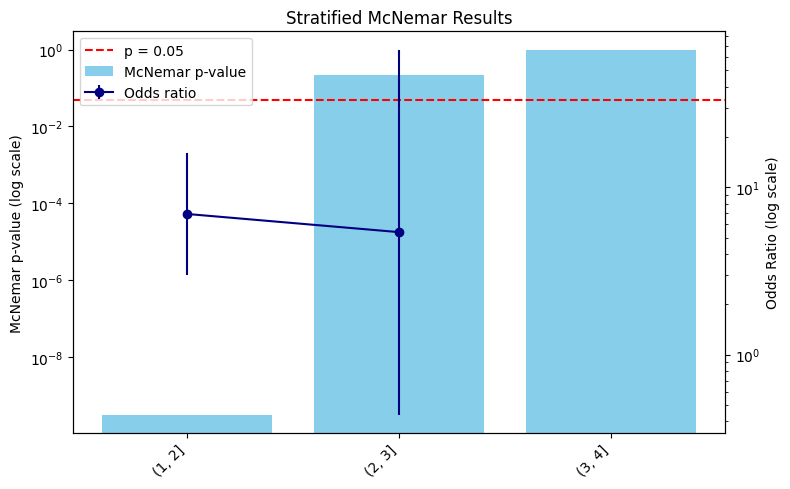

Stratified McNemar p = {'oddsratio': 27.587943947921847, 'pvalue': 1.50111492014382e-07}


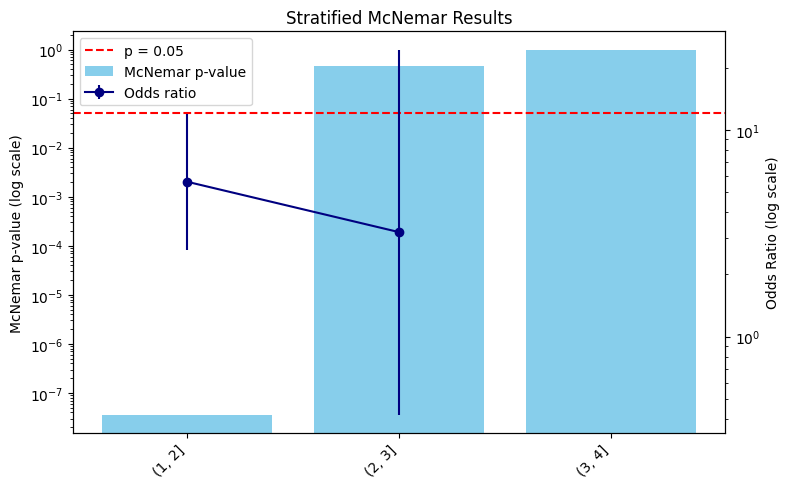

Stratified McNemar p = {'oddsratio': 24.8678405297651, 'pvalue': 6.139818199413227e-07}


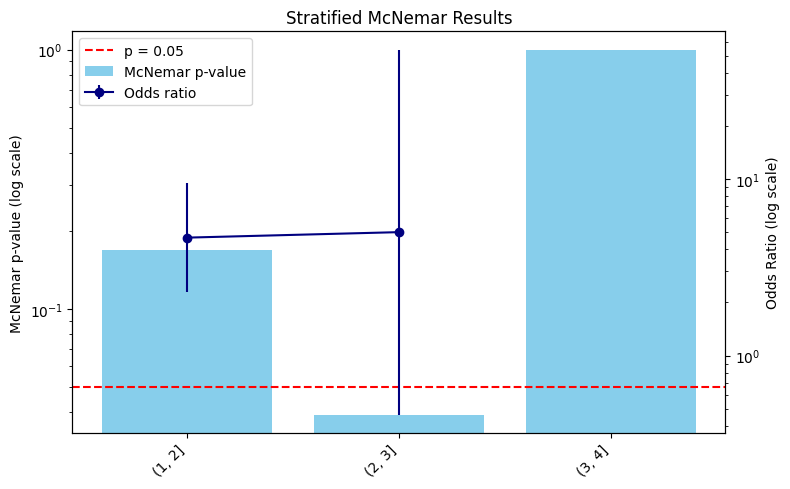

Stratified McNemar p = {'oddsratio': 23.0632650793835, 'pvalue': 1.5675723644692496e-06}


In [8]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="system_num_protein_chains",
    bins=[1,2,3,4]
)
print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="system_num_protein_chains",
    bins=[1,2,3,4]
)
print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="system_num_protein_chains",
    bins=[1,2,3,4]
)
print("Stratified McNemar p =", stratified_analysis['cmh'])

### ligand_num_rot_bonds

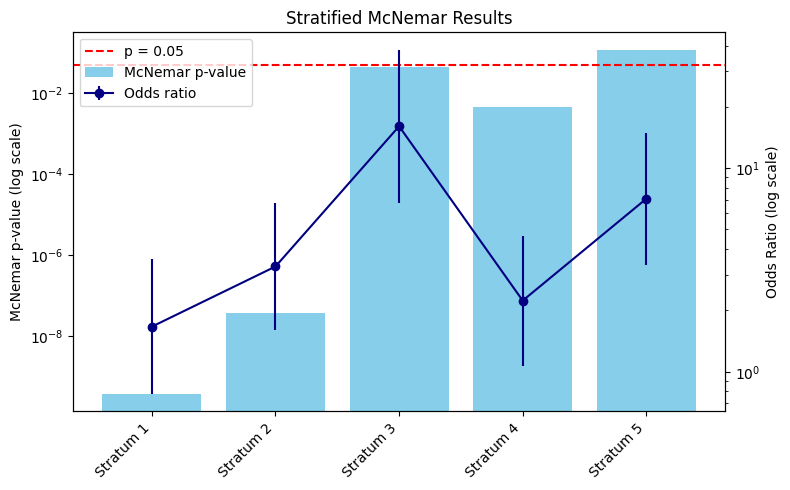

Stratified McNemar p = {'oddsratio': 75.32988144116996, 'pvalue': 0.0}


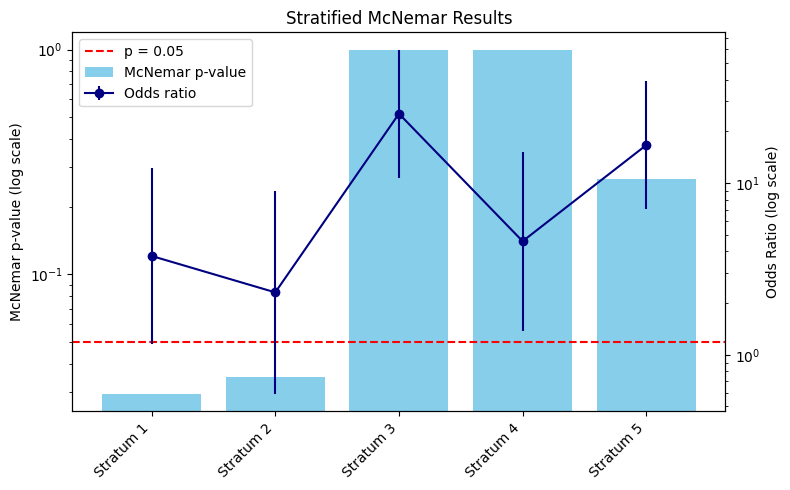

Stratified McNemar p = {'oddsratio': 128.95512155537747, 'pvalue': 0.0}


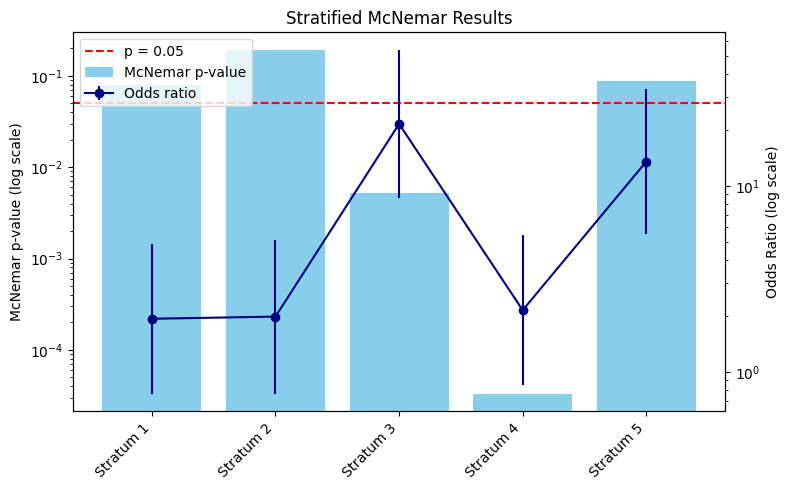

Stratified McNemar p = {'oddsratio': 82.93670523603767, 'pvalue': 0.0}


In [9]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_rot_bonds",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_rot_bonds",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_rot_bonds",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

### ligand_num_hbd

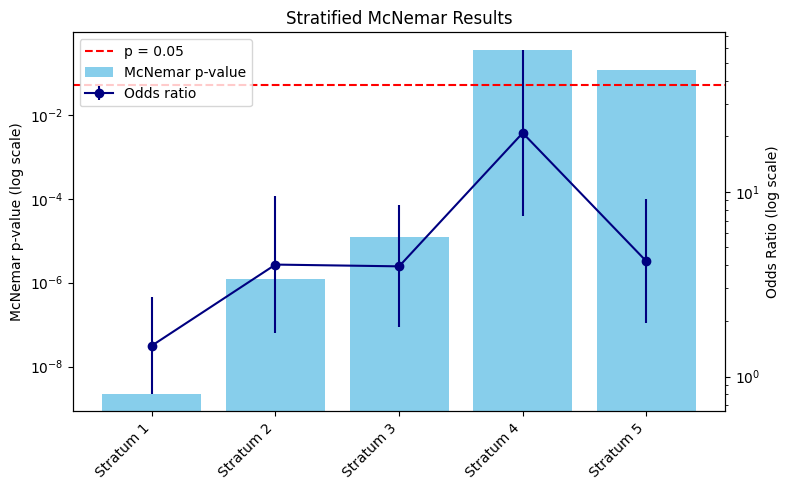

Stratified McNemar p = {'oddsratio': 59.766508441248725, 'pvalue': 1.0658141036401503e-14}


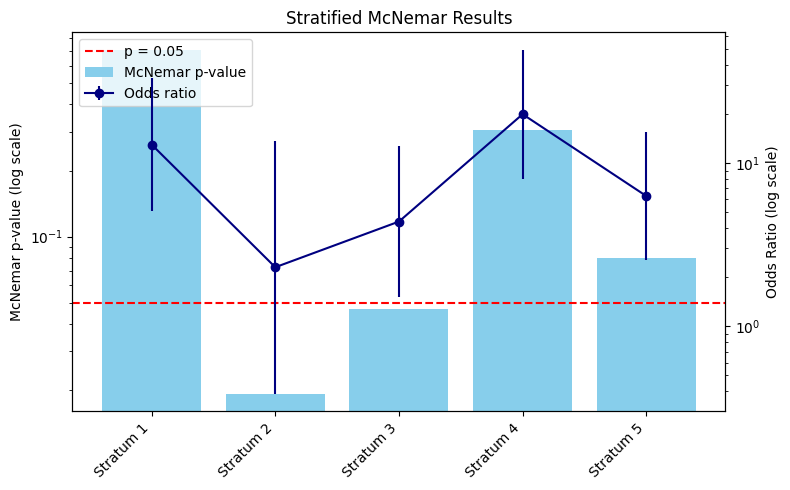

Stratified McNemar p = {'oddsratio': 108.26020454877612, 'pvalue': 0.0}


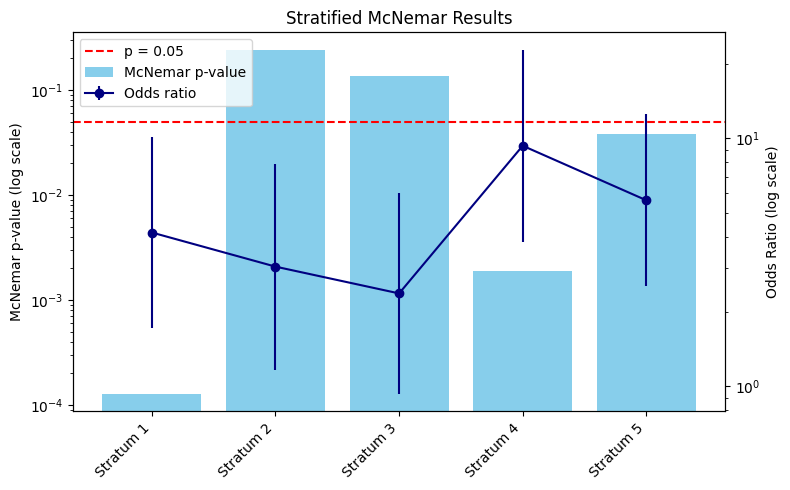

Stratified McNemar p = {'oddsratio': 64.88831358145544, 'pvalue': 7.771561172376096e-16}


In [10]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_hbd",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_hbd",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_hbd",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

#### ligand_num_hba

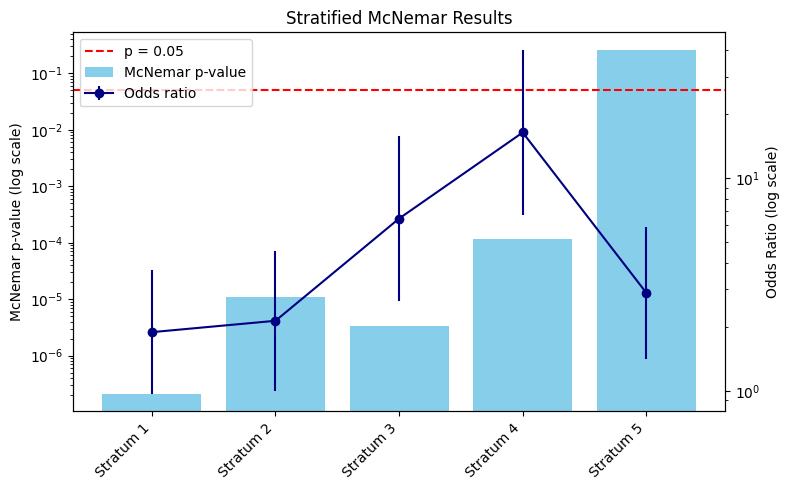

Stratified McNemar p = {'oddsratio': 65.61767363763862, 'pvalue': 5.551115123125783e-16}


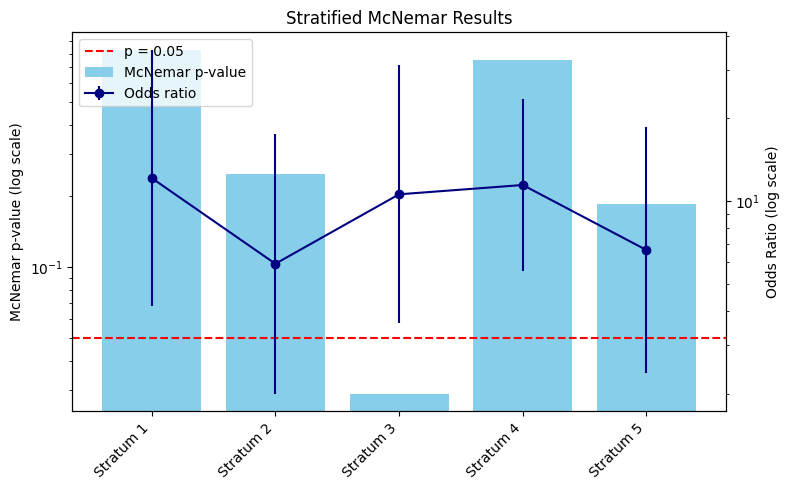

Stratified McNemar p = {'oddsratio': 124.29265752651548, 'pvalue': 0.0}


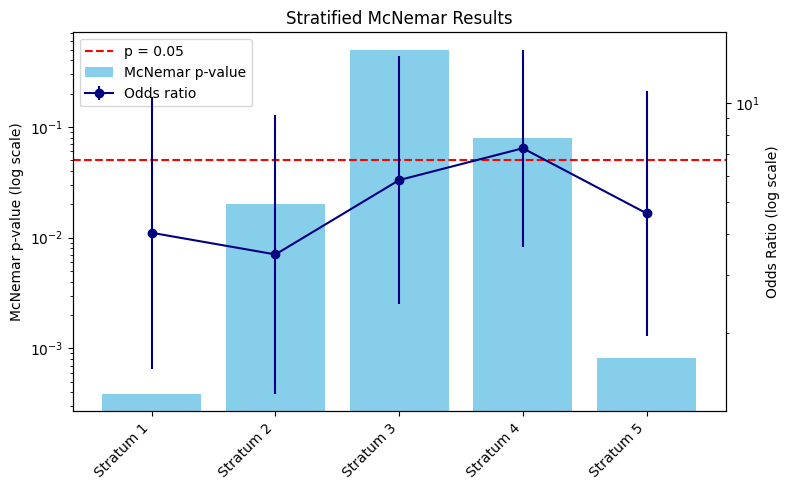

Stratified McNemar p = {'oddsratio': 80.85523942379913, 'pvalue': 0.0}


In [11]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_hba",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_hba",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_hba",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

### ligand_num_rings

In [12]:
df_combined['ligand_num_rings'].value_counts()

ligand_num_rings
2.0     7611
3.0     7242
4.0     2722
1.0     2207
5.0     1372
0.0     1268
6.0      803
7.0      270
8.0       35
12.0      10
11.0       5
Name: count, dtype: int64

/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/stats/contingency_tables.py:1050: RuntimeWarning: invalid value encountered in divide
  self._apb * self._apc / self._n)
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/stats/contingency_tables.py:1056: RuntimeWarning: invalid value encountered in divide
  denom /= (self._n**2 * (self._n - 1))


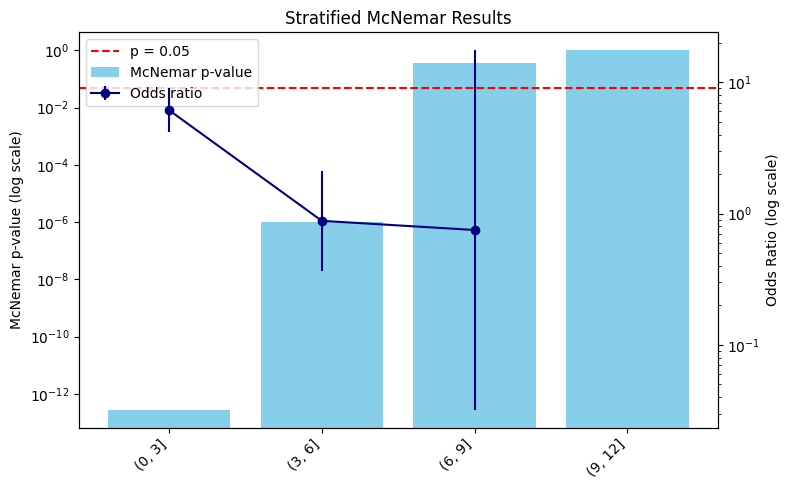

Stratified McNemar p = {'oddsratio': nan, 'pvalue': nan}


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/stats/contingency_tables.py:1056: RuntimeWarning: invalid value encountered in divide
  denom /= (self._n**2 * (self._n - 1))


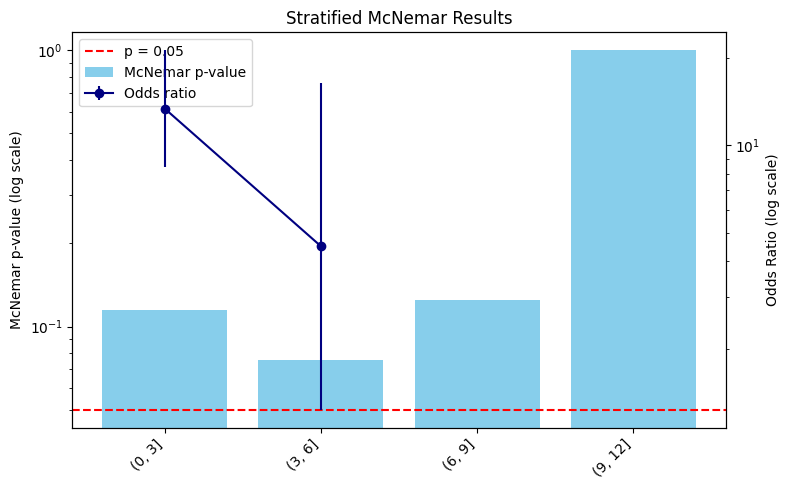

Stratified McNemar p = {'oddsratio': nan, 'pvalue': nan}


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/stats/contingency_tables.py:1050: RuntimeWarning: invalid value encountered in divide
  self._apb * self._apc / self._n)
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/stats/contingency_tables.py:1056: RuntimeWarning: invalid value encountered in divide
  denom /= (self._n**2 * (self._n - 1))


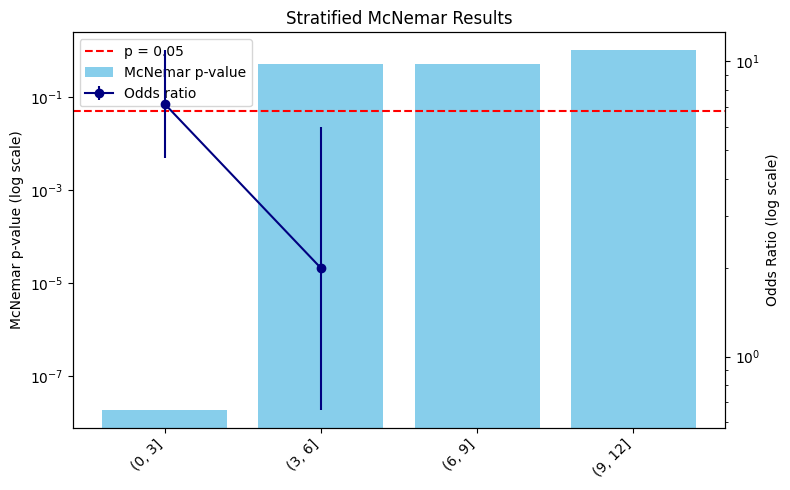

Stratified McNemar p = {'oddsratio': nan, 'pvalue': nan}


In [13]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_rings",
    bins=[0,3,6,9,12]
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_rings",
    bins=[0,3,6,9,12]
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_rings",
    bins=[0,3,6,9,12]
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

### entry_resolution

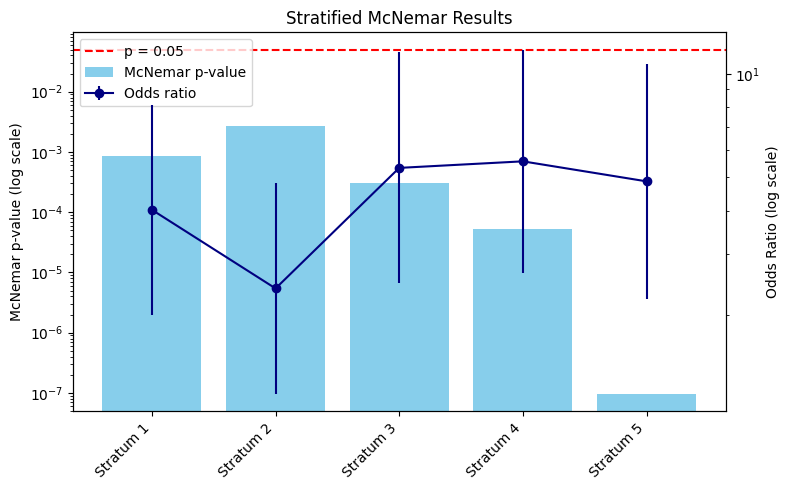

Stratified McNemar p = {'oddsratio': 77.79777791942342, 'pvalue': 0.0}


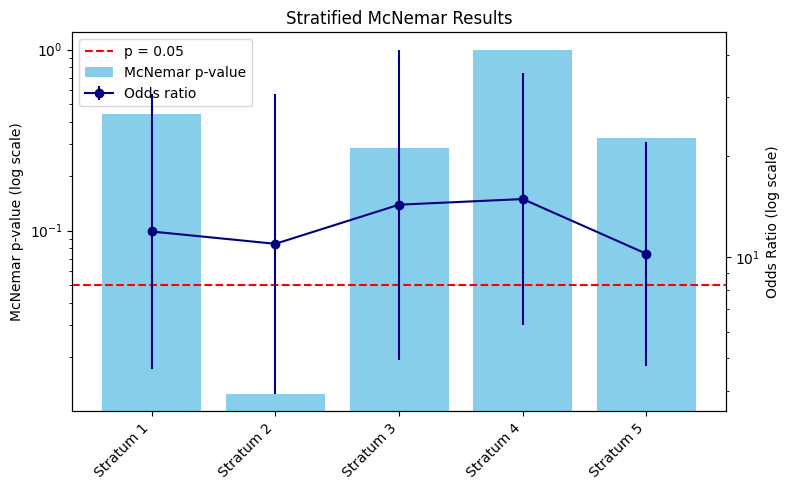

Stratified McNemar p = {'oddsratio': 180.1506401521644, 'pvalue': 0.0}


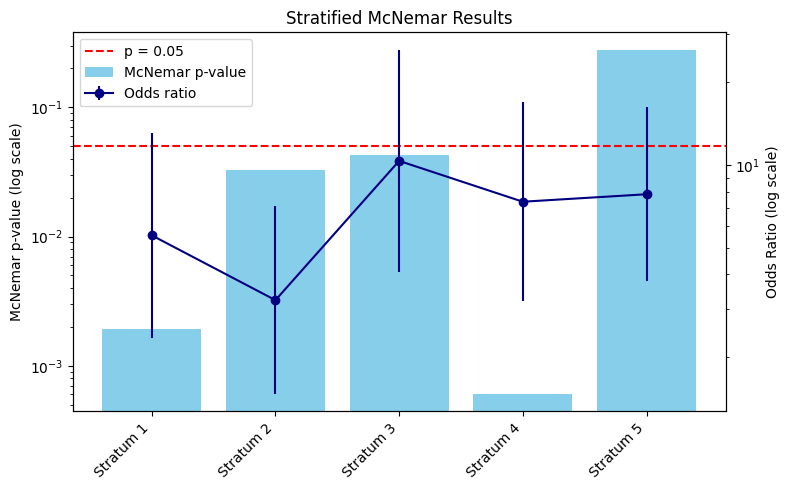

Stratified McNemar p = {'oddsratio': 111.31618464701026, 'pvalue': 0.0}


In [14]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="entry_resolution",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="entry_resolution",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="entry_resolution",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

### entry_validation_molprobity

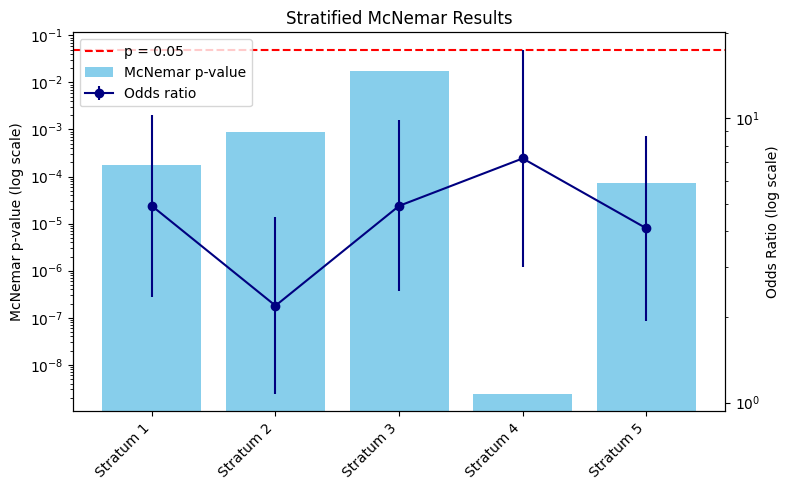

Stratified McNemar p = {'oddsratio': 79.15364731828176, 'pvalue': 0.0}


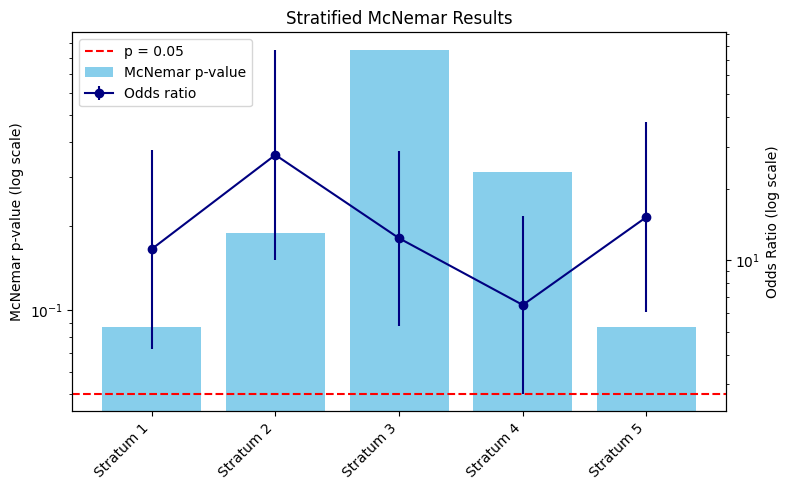

Stratified McNemar p = {'oddsratio': 193.76990458672176, 'pvalue': 0.0}


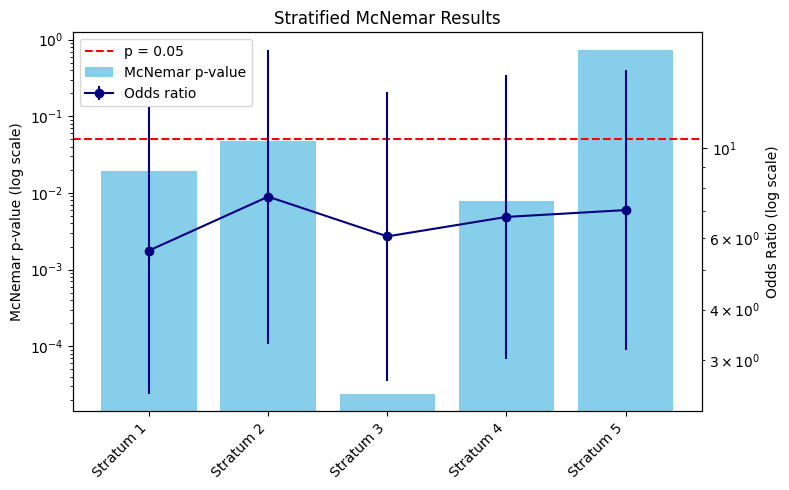

Stratified McNemar p = {'oddsratio': 116.76351130011898, 'pvalue': 0.0}


In [15]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="entry_validation_molprobity",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="entry_validation_molprobity",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="entry_validation_molprobity",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

### system_pocket_residues

### system_num_interactions

### ligand_molecular_weight

### ligand_crippen_clogp

### ligand_num_interactions

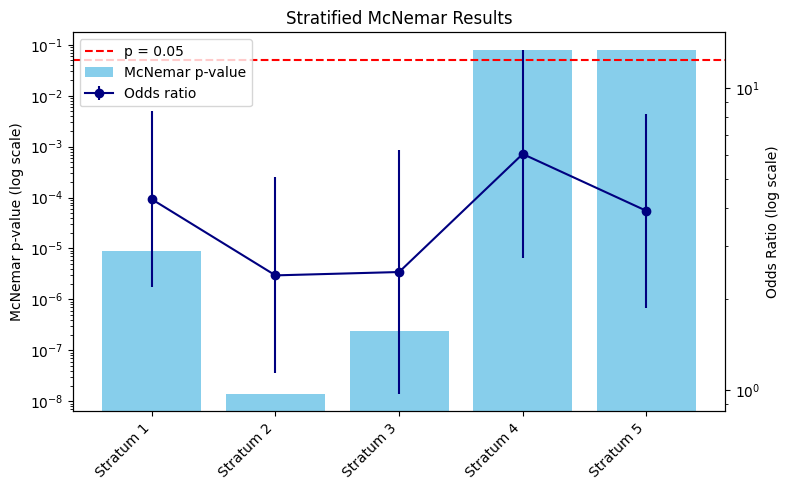

Stratified McNemar p = {'oddsratio': 58.8113576820258, 'pvalue': 1.7319479184152442e-14}


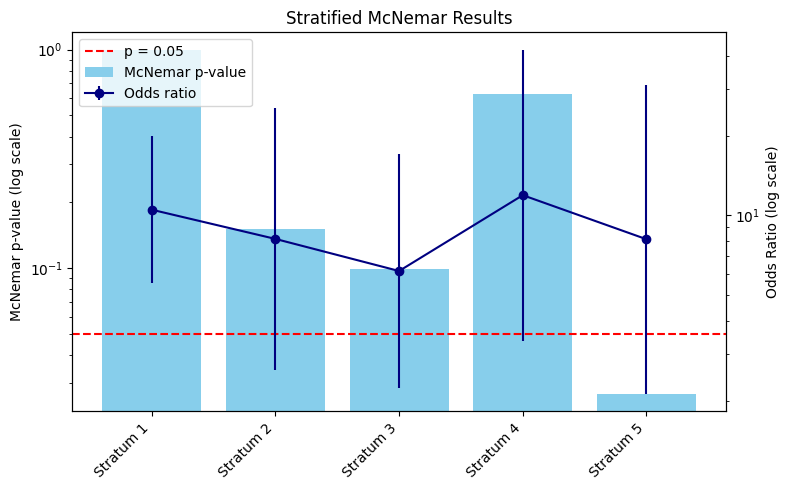

Stratified McNemar p = {'oddsratio': 116.15199763726741, 'pvalue': 0.0}


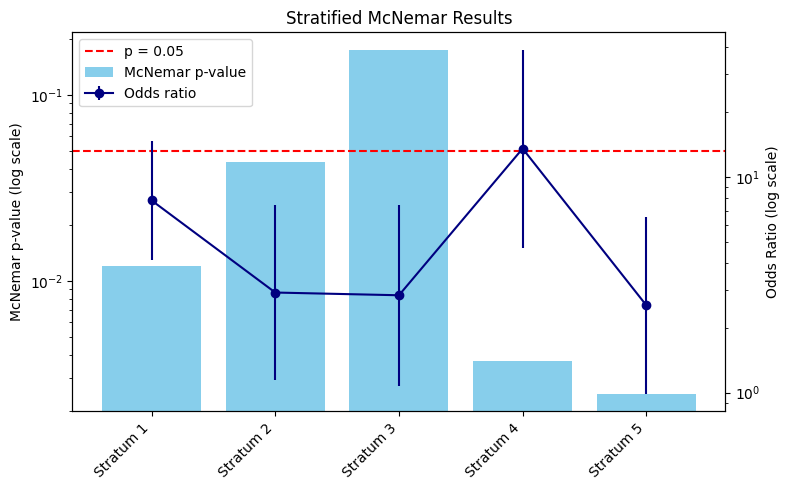

Stratified McNemar p = {'oddsratio': 79.79458600263241, 'pvalue': 0.0}


In [16]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="system_num_interactions",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="system_num_interactions",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="system_num_interactions",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

### ligand_num_neighboring_residues

### ligand_num_interacting_residues

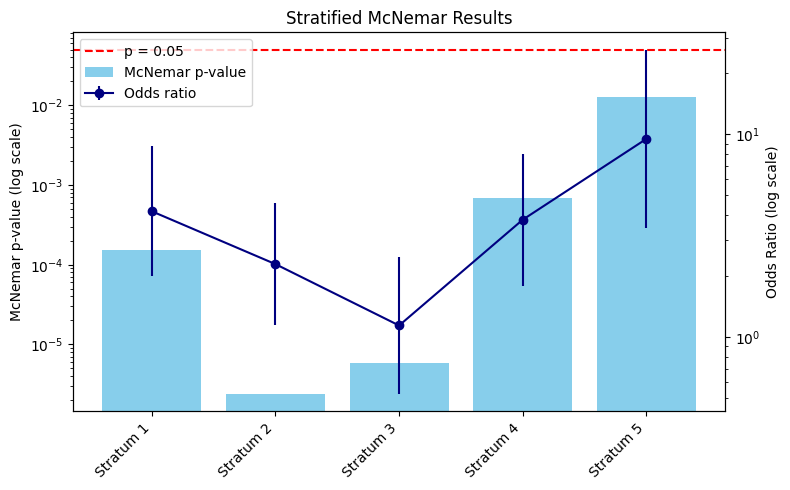

Stratified McNemar p = {'oddsratio': 41.63040045254289, 'pvalue': 1.1026524138202376e-10}


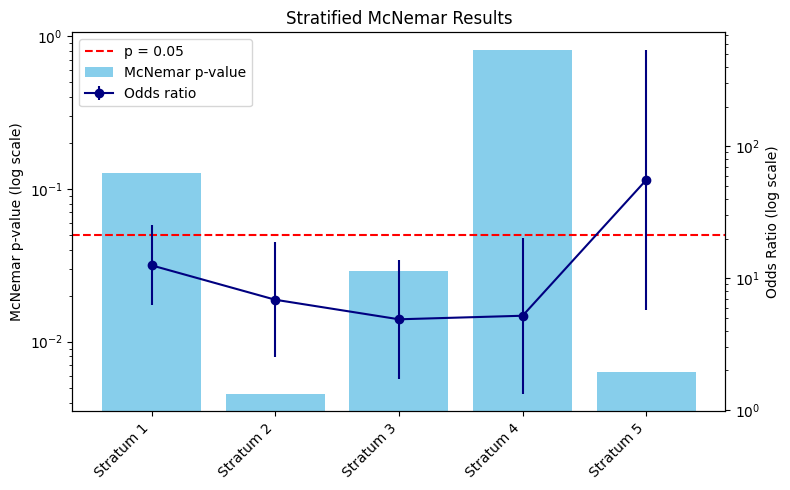

Stratified McNemar p = {'oddsratio': 106.35930620272158, 'pvalue': 0.0}


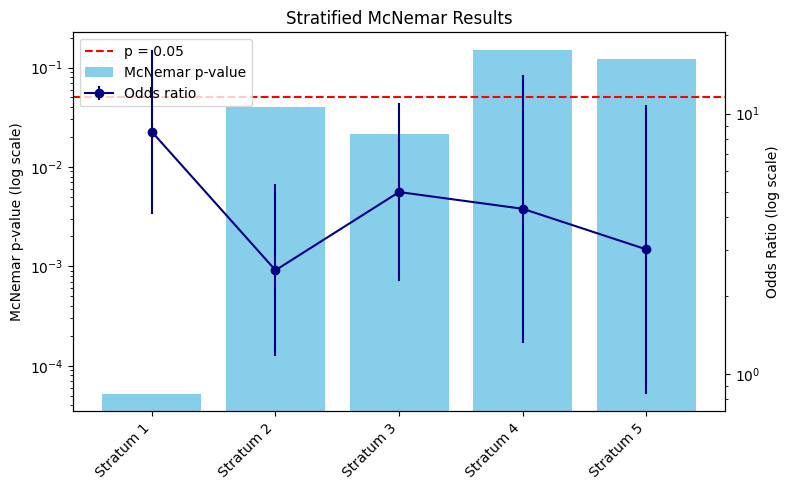

Stratified McNemar p = {'oddsratio': 67.67957359187838, 'pvalue': 2.220446049250313e-16}


In [17]:
# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only"],
    methods_group2=["icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_interacting_residues",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only","surfdock", "chai-1"],
    methods_group2=["vina", "gnina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_interacting_residues",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

# stratified_analysis = property_analysis.stratified_success_analysis(
stratified_analysis = property_analysis.stratified_mcnemar_analysis(
    methods_group1=["diffdock_pocket_only", "chai-1", "surfdock"],
    methods_group2=["vina", "icm"],
    rmsd_threshold=2.0,
    property_name="ligand_num_interacting_residues",
)

print("Stratified McNemar p =", stratified_analysis['cmh'])

## Distribution of the features

In [6]:
properties = [
    "ligand_num_rot_bonds",
    "ligand_num_hbd",
    "ligand_num_hba",
    "ligand_num_rings",
    "entry_resolution",
    "entry_validation_molprobity",
    "syestem_num_interactions",
    "ligand_molecular_weight",
    "ligand_crippen_clogp",
    "ligand_num_interacting_residues",
    "ligand_num_neighboring_residues",
]

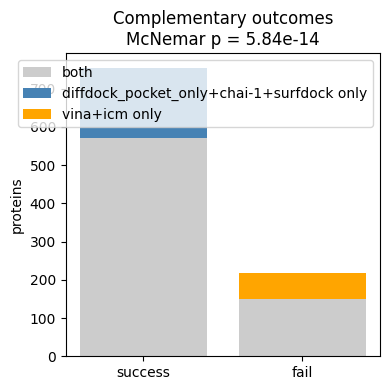

              count        mean      median         std         min  \
group                                                                 
both_failure    109  446.426022  408.174395  128.294652  200.032088   
both_success    542  401.850302  375.674109  135.232892  164.068474   
method1_only    144  404.465559  400.582011  139.876017  200.079707   
method2_only     64  404.483539  347.063084  143.065681  164.068474   

                     max  
group                     
both_failure  797.022883  
both_success  787.172785  
method1_only  787.430050  
method2_only  785.157135  
{'anova': {'f_stat': 11.635074976694332, 'p_value': 1.770336397300079e-07}, 'kruskal_wallis': {'stat': 25.06021243786067, 'p_value': 1.4999309792919289e-05}}


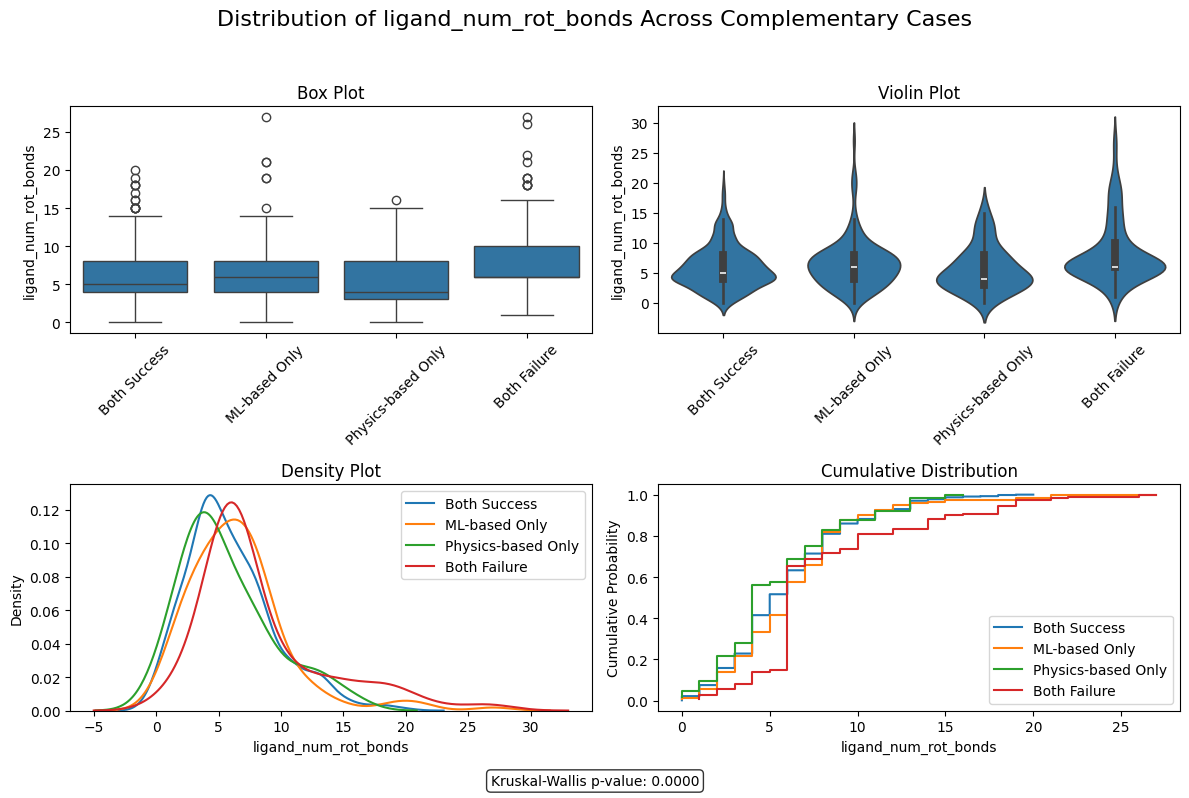

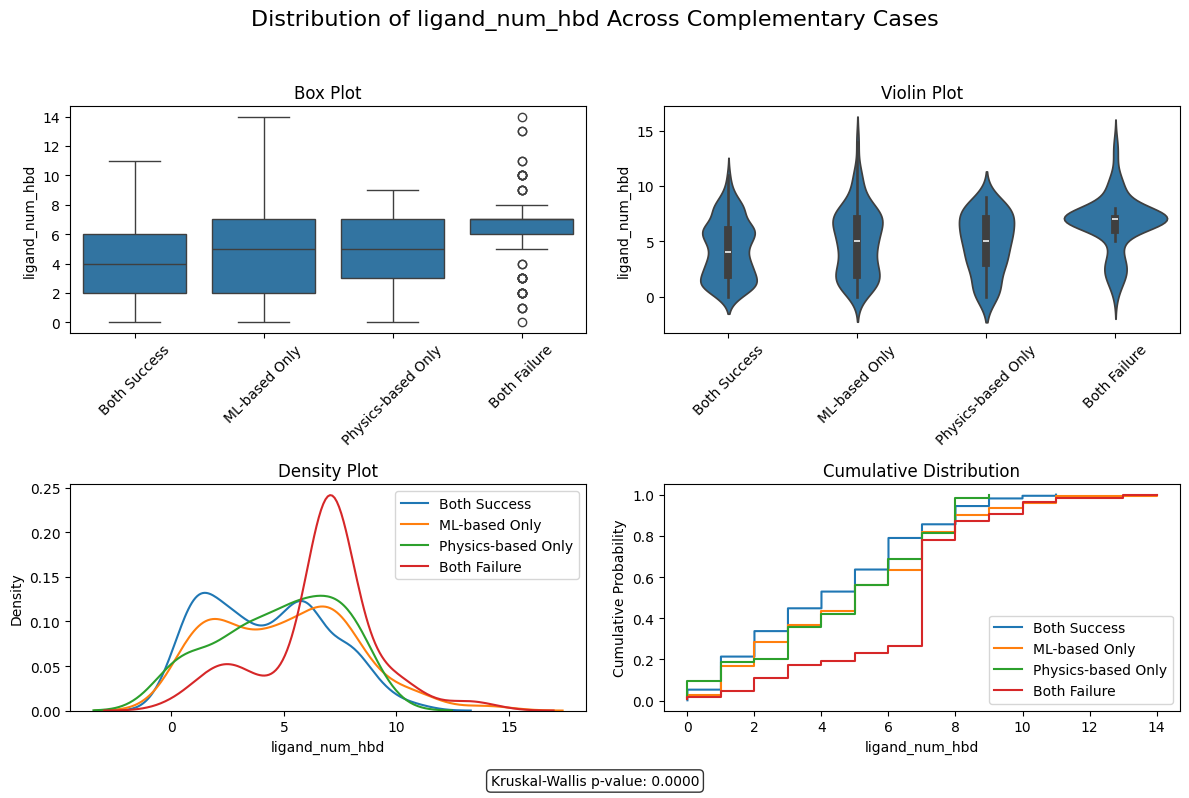

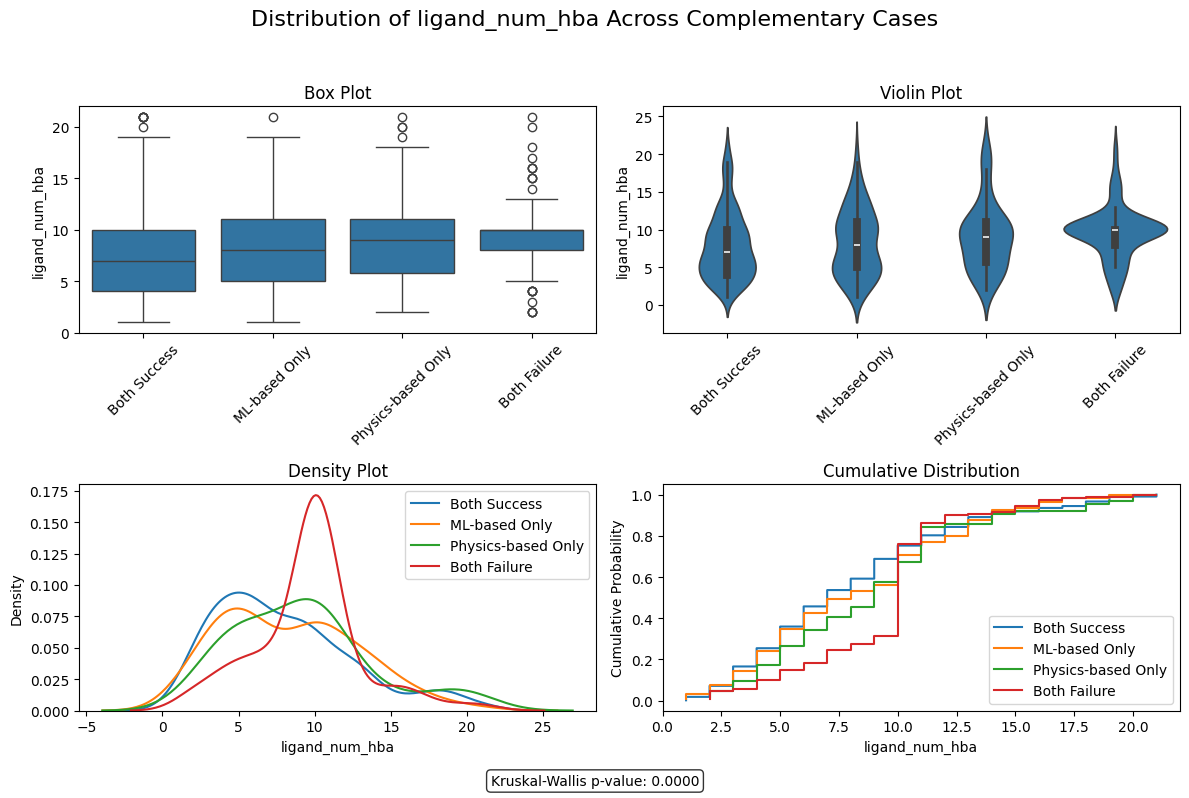

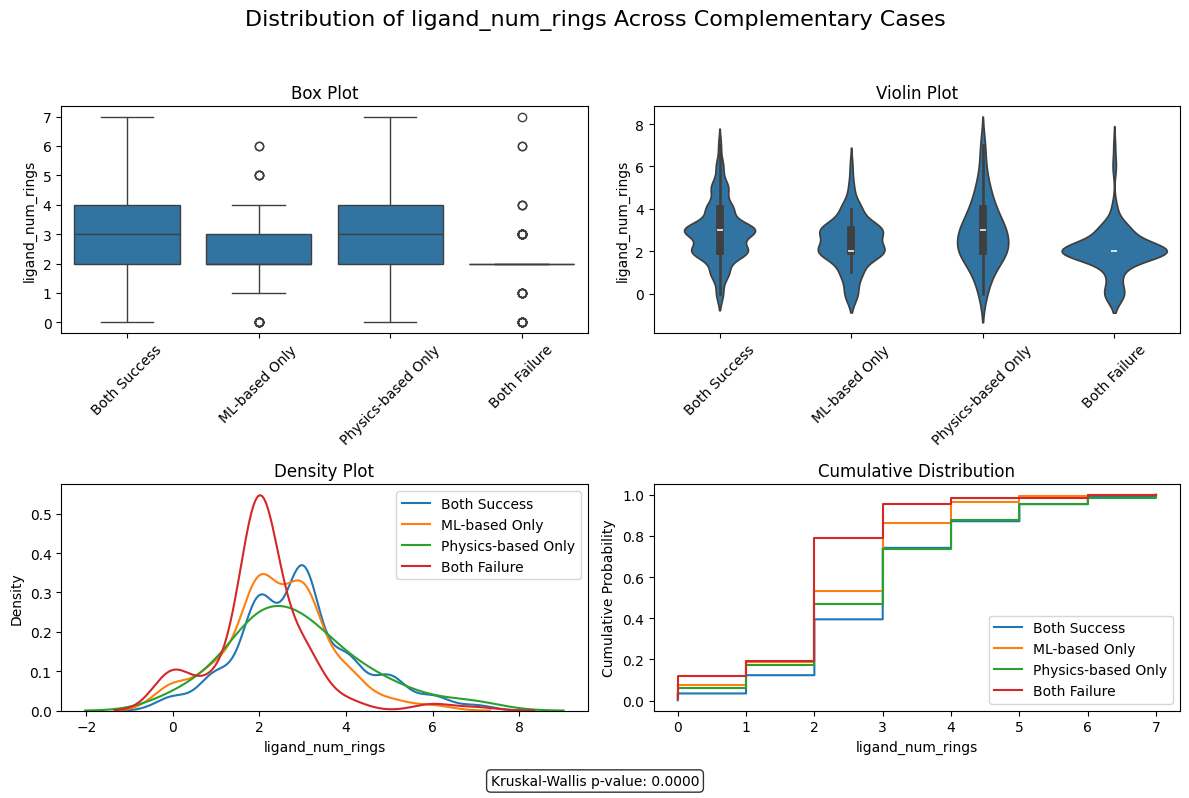

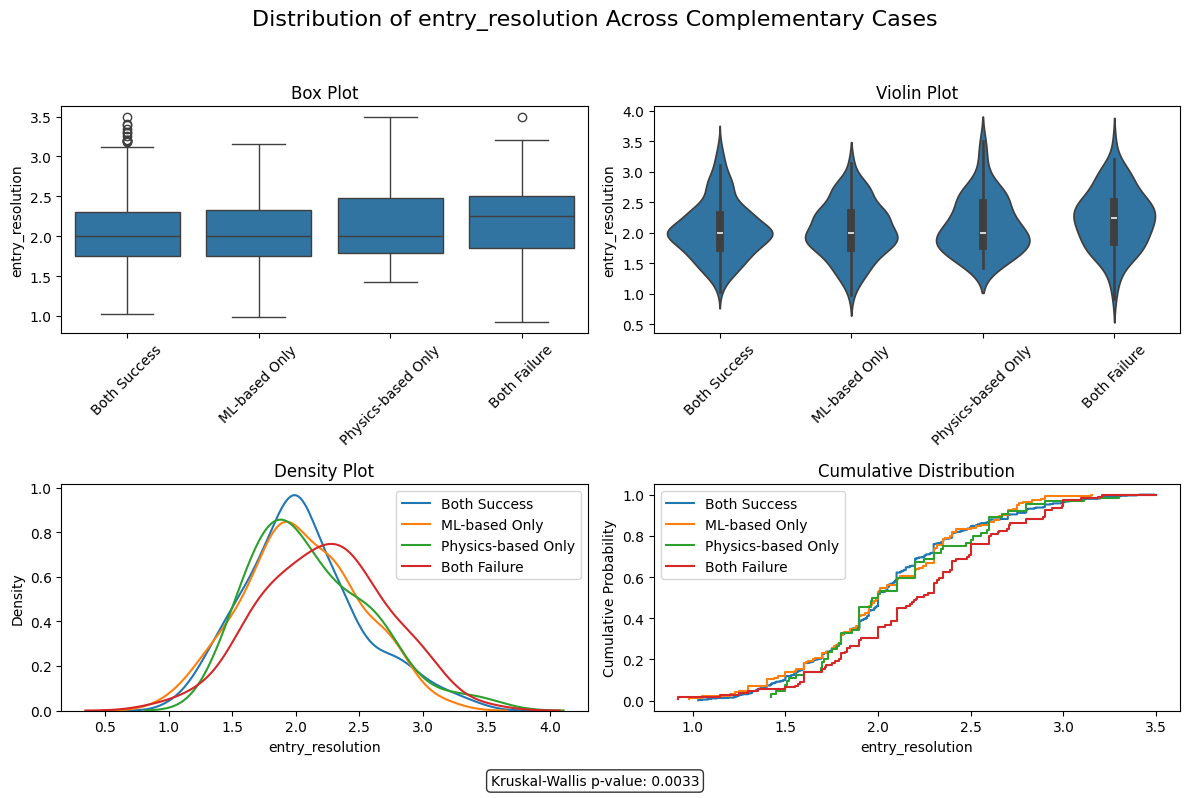

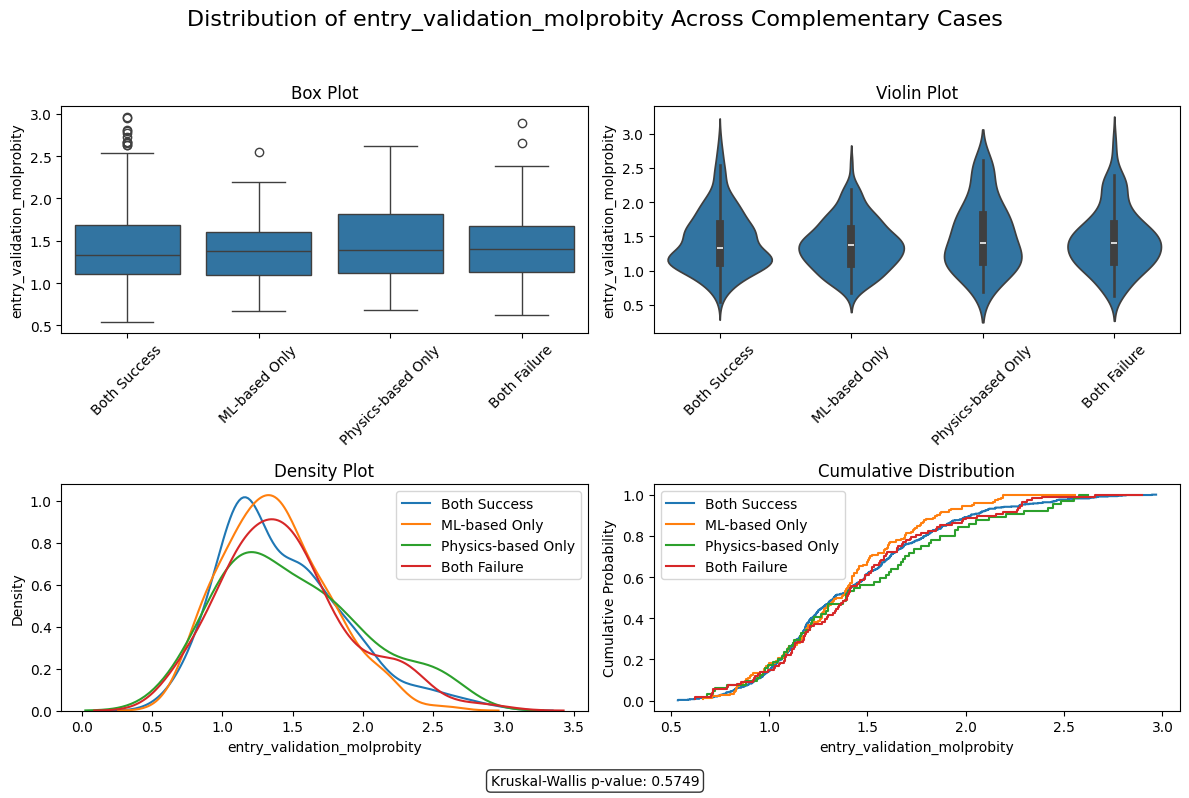

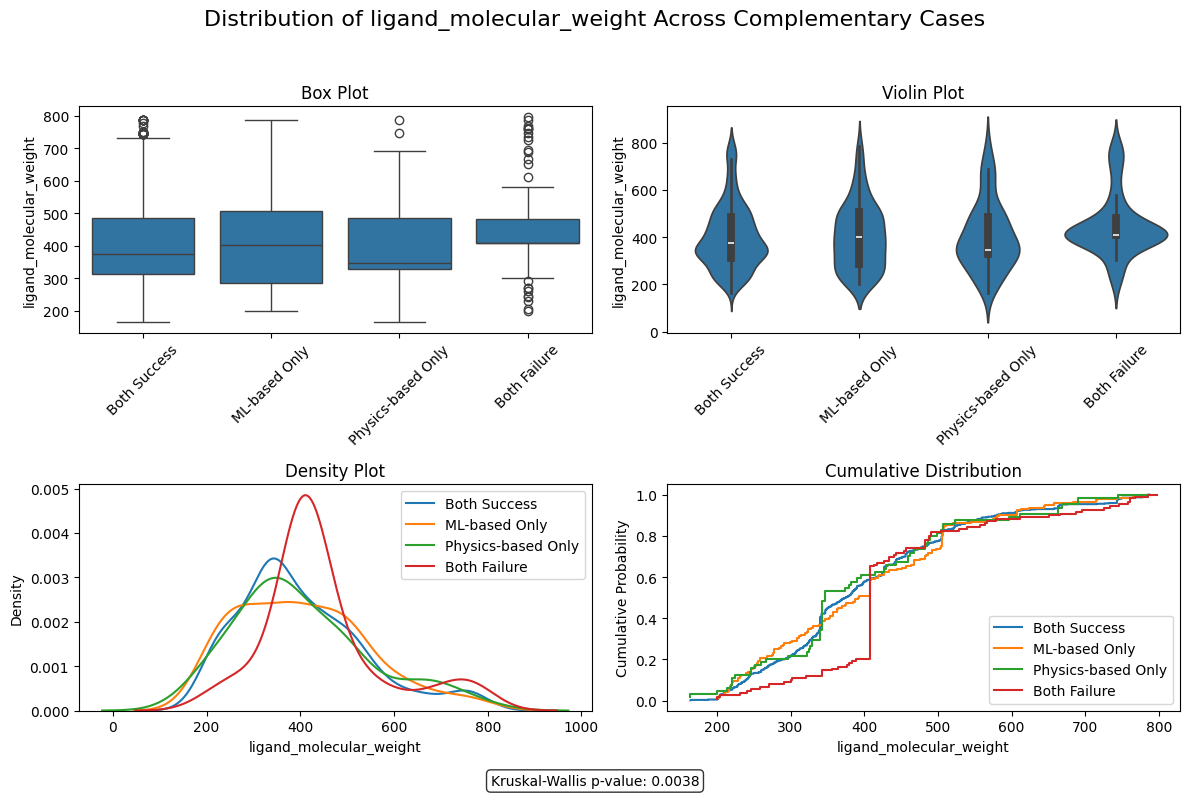

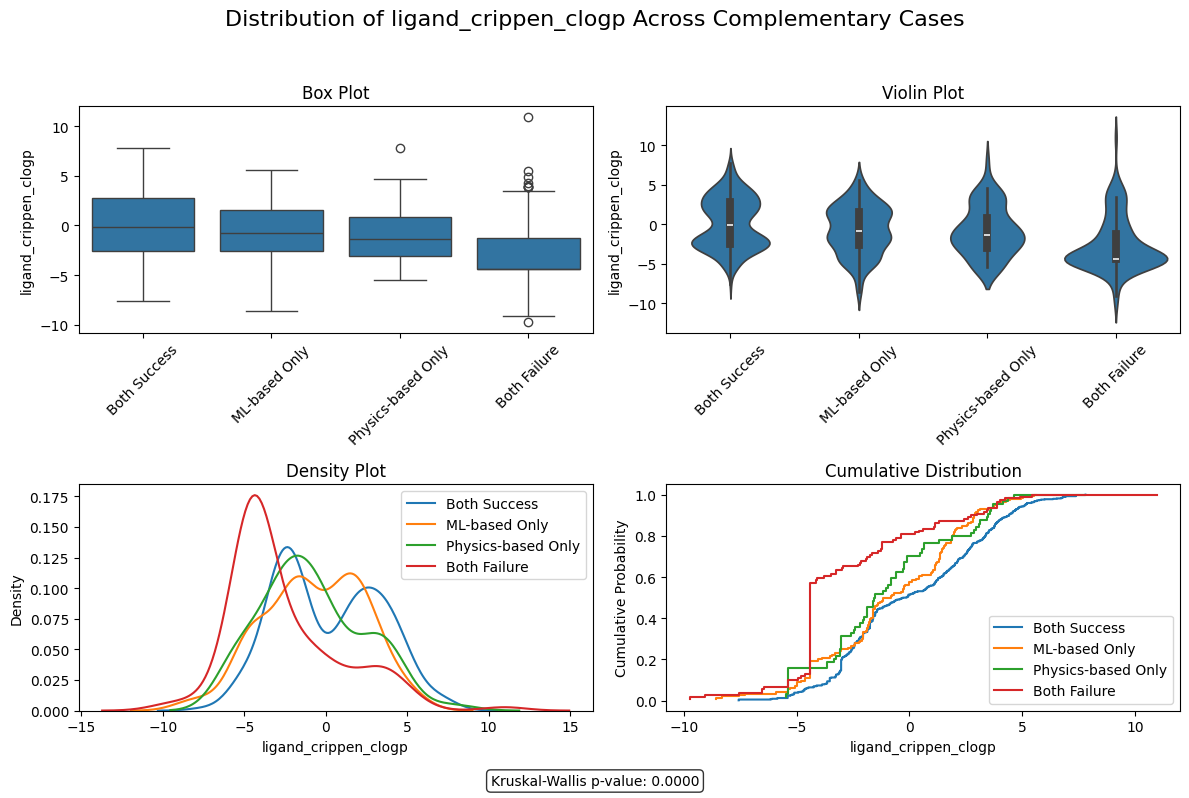

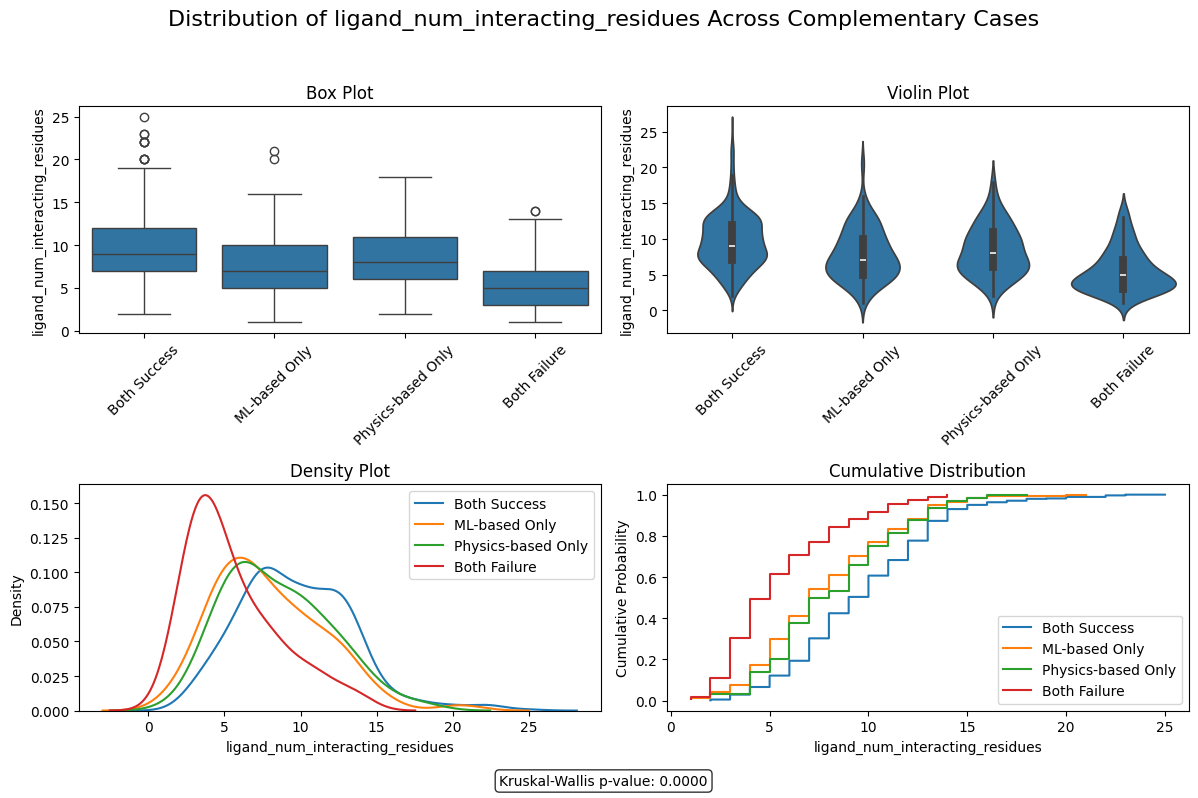

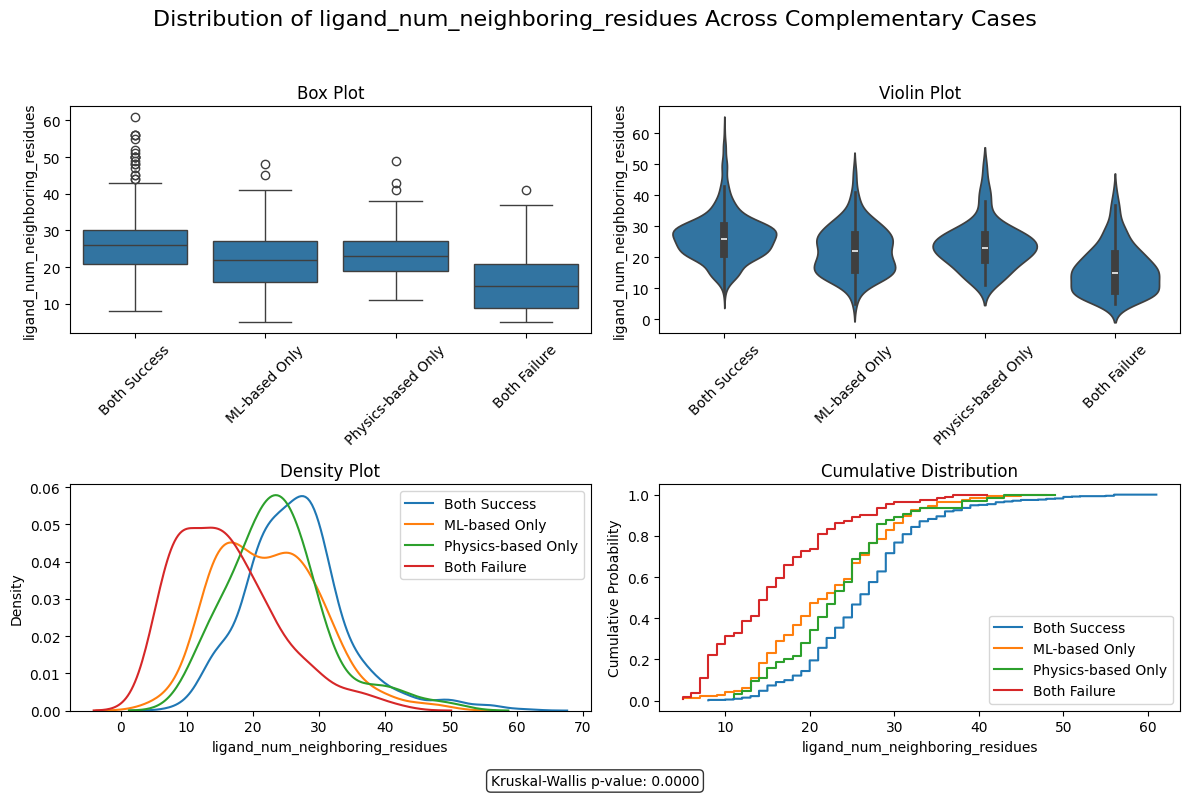

In [8]:
# First run the complementary analysis
property_analysis = PropertyAnalysis(df_combined)
complementary_results = property_analysis.complementary_success_analysis(
    method1=['diffdock_pocket_only', 'chai-1', 'surfdock'],  # ML methods
    method2=['vina', 'icm'],                   # Physics-based methods
    rmsd_threshold=2.0,
    plot=True
)

# Then analyze property distributions across complementary cases
property_distributions = property_analysis.compare_property_distributions_in_complementary_cases(
    complementary_results=complementary_results,
    properties=properties,
    method_labels=('ML-based', 'Physics-based'),
    property_types={
        'ligand_molecular_weight': 'continuous',
        'ligand_num_rot_bonds': 'continuous',
        'ligand_num_hbd': 'continuous',
        'ligand_num_hba': 'continuous',
        'ligand_num_rings': 'continuous',
        'entry_resolution': 'continuous',
        'entry_validation_molprobity': 'continuous',
        'system_num_interactions': 'continuous',
        'ligand_crippen_clogp': 'continuous',
        'ligand_num_interacting_residues': 'continuous',
        'ligand_num_neighboring_residues': 'continuous'
    },
    plot=True
)

# To view the summary statistics
print(property_distributions['summary_stats']['ligand_molecular_weight'])

# To access the statistical test results
print(property_distributions['test_results']['ligand_num_rot_bonds'])